In [2]:
import numpy as np
import pandas as pd

In [3]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

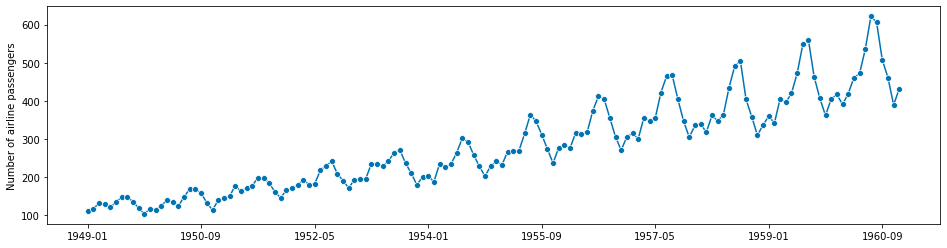

In [4]:
y = load_airline()

# plotting for visualization
plot_series(y)

In [5]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', length=144, freq='M')

In [6]:
type(y)

pandas.core.series.Series

### 1.2 Basic deployment workflow - batch fitting and forecasting<a class="anchor" id="section_1_2"></a>

#### 1.2.1 the basic deployment workflow in a nutshell<a class="anchor" id="section_1_2_1"></a>

for convenience, we present the basic deployment workflow in one cell.
This uses the same data, but different forecaster: predicting the latest value observed in the same month.

In [7]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

In [8]:
# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

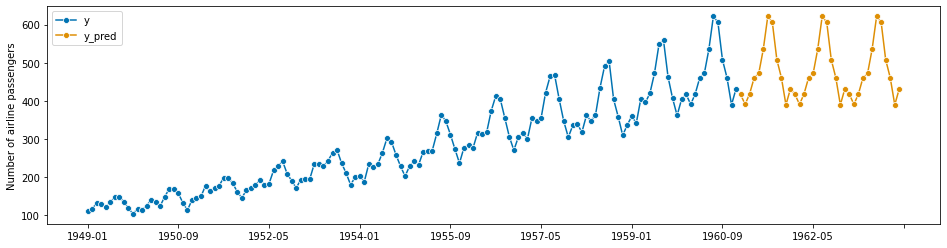

In [9]:
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

#### 1.2.2 forecasters that require the horizon already in `fit` <a class="anchor" id="section_1_2_2"></a>

Some forecasters need the forecasting horizon provided already in `fit`. Such forecasters will produce informative error messages when it is not passed in `fit`. All forecaster will remember the horizon when already passed in `fit` for prediction. The modified workflow to allow for such forecasters in addition is as follows:

In [10]:
# step 1: data specification
y = load_airline()

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, fh=fh)

# step 5: querying predictions
y_pred = forecaster.predict()

#### 1.2.3 forecasters that can make use of exogeneous data<a class="anchor" id="section_1_2_3"></a>

Many forecasters can make use of exogeneous time series, i.e., other time series that are not forecast, but are useful for forecasting `y`. Exogeneous time series are always passed as an `X` argument, in `fit`, `predict`, and other methods (see below). Exogeneous time series should always be passed as `pandas.DataFrames`. Most forecasters that can deal with exogeneous time series will assume that the time indices of `X` passed to `fit` are a super-set of the time indices in `y` passed to `fit`; and that the time indices of `X` passed to `predict` are a super-set of time indices in `fh`, although this is not a general interface restriction. Forecasters that do not make use of exogeneous time series still accept the argument (and do not use it internally).

The general workflow for passing exogeneous data is as follows:

In [11]:
# step 1: data specification
y = load_airline()
# we create some dummy exogeneous data
X = pd.DataFrame(index=y.index)

# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y, X=X, fh=fh)

# step 5: querying predictions
y_pred = forecaster.predict(X=X)

#### 1.2.4 prediction intervals<a class="anchor" id="section_1_2_4"></a>

`sktime` provides a unified interface to return prediction interval when forecasting. This is possible directly in the `predict` function, by setting the `return_pred_int` argument to `True`. The `predict` method then returns a second argument, Not all forecasters are capable of returning prediction intervals, in which case an error will be raised.

Obtaining prediction intervals can be done as part of any workflow involving `predict`, by adding the argument `return_pred_int` - below, we illustrate this by modifying the basic workflow in Section 1.2:

In [12]:
from sktime.forecasting.theta import ThetaForecaster

In [13]:
# simple workflow
y = load_airline()
fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y)

# setting return_pred_int argument to True; alpha determines percentiles
#  intervals are lower = alpha/2-percentile, upper = (1-alpha/2)-percentile
alpha = 0.05  # 2.5%/97.5% prediction intervals
y_pred, y_pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)

/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:216: FutureWarning: return_pred_int in predict() will be deprecated;please use predict_interval() instead to generate prediction intervals.
  warn(


`y_pred_ints` is a `pandas.DataFrame` with columns `lower` and `upper`, and rows the indices for which forecasts were made (same as in `y_pred`). Entries are lower/upper (as column name) bound of the nominal alpha predictive interval for the index in the same row.

In [14]:
y_pred_ints

,lower,upper
1961-01,413.873755,468.688317
1961-02,396.979011,462.124925
1961-03,454.013504,528.063109
1961-04,435.998232,517.990291
1961-05,436.352089,525.582418
1961-06,498.874797,594.798754
1961-07,553.282845,655.462879
1961-08,548.675556,656.750129
1961-09,468.520987,582.184821
1961-10,398.349800,517.340645


pretty-plotting the predictive interval forecasts:

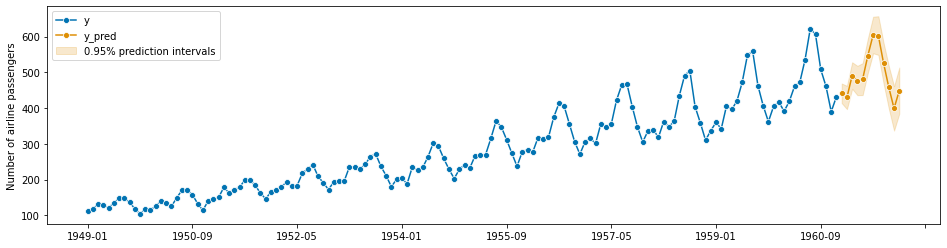

In [15]:
fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["lower"],
    y_pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

NOTE: this should be turned into a one-liner, by moving this to `utils.plotting` - contributions are appreciated.

### 1.3 basic evaluation workflow - evaluating a batch of forecasts against ground truth observations<a class="anchor" id="section_1_3"></a>


To properly interpret numbers like this, it is useful to understand properties of the metric in question (e.g., lower is better), and to compare against suitable baselines and contender algorithms (see step 5).

In [24]:
# option 2: using the composable class interface
mape = MeanAbsolutePercentageError(symmetric=False)
# the class interface allows to easily construct variants of the MAPE
#  e.g., the non-symmetric verion
# it also allows for inspection of metric properties
#  e.g., are higher values better (answer: no)?
mape.greater_is_better

False

NOTE: some metrics, such as `mean_absolute_scaled_error`, also require the training set for evaluation. In this case, the training set should be passed as a `y_train` argument. Refer to the API reference on individual metrics.

NOTE: the workflow is the same for forecasters that make use of exogeneous data - no `X` is passed to the metrics.

#### 1.3.1 the basic batch forecast evaluation workflow in a nutshell - function metric interface<a class="anchor" id="section_1_3_1"></a>

For convenience, we present the basic batch forecast evaluation workflow in one cell.
This cell is using the lean function metric interface.

In [26]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

0.145427686270316
0.13189432350948402


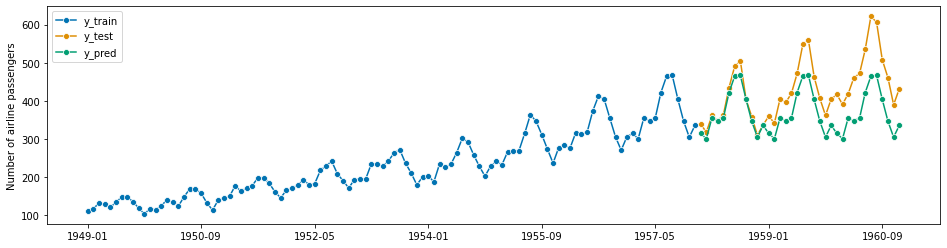

In [67]:
# step 1: splitting historical data
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 2: running the basic forecasting workflow
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])


# step 3: specifying the evaluation metric and
# step 4: computing the forecast performance
print(mean_absolute_percentage_error(y_test, y_pred))
print(mape(y_test, y_pred))

# step 5: testing forecast performance against baseline
# under development

### 1.4.1 updating a forecaster with the `update` method<a class="anchor" id="section_1_4_1"></a>

The `update` method can be called when a forecaster is already fitted, to ingest new data and make updated forecasts - this is referred to as an "update step".

After the update, the forecaster's internal "now" state (the `cutoff`) is set to the latest time stamp seen in the update batch (assumed to be later than previously seen data).

The general pattern is as follows:

1. specify a forecasting strategy
2. specify a relative forecasting horizon
3. fit the forecaster to an initial batch of data using `fit`
4. make forecasts for the relative forecasting horizon, using `predict`
5. obtain new data; use `update` to ingest new data
6. make forecasts using `predict` for the updated data
7. repeat 5 and 6 as often as required

**Example**: suppose that, in the airline example, we want to make forecasts a year ahead, but every month, starting December 1957. The first few months, forecasts would be made as follows:

In [30]:
from sktime.datasets import load_airline
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series

In [31]:
# we prepare the full data set for convenience
# note that in the scenario we will "know" only part of this at certain time points
y = load_airline()

In [32]:
# December 1957

# this is the data known in December 1975
y_1957Dec = y[:-36]

# step 1: specifying the forecasting strategy
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

# step 2: specifying the forecasting horizon: one year ahead, all months
fh = np.arange(1, 13)

# step 3: this is the first time we use the model, so we fit it
forecaster.fit(y_1957Dec)

# step 4: obtaining the first batch of forecasts for Jan 1958 - Dec 1958
y_pred_1957Dec = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

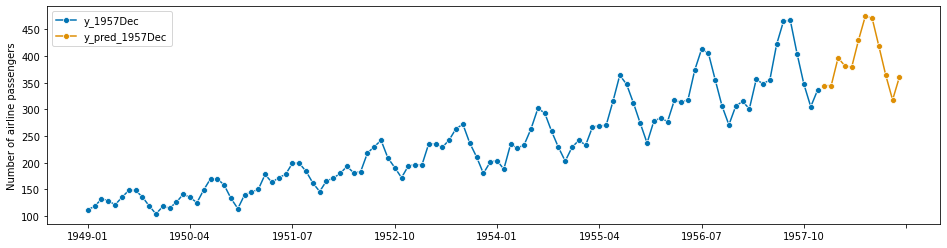

In [33]:
# plotting predictions and past data
plot_series(y_1957Dec, y_pred_1957Dec, labels=["y_1957Dec", "y_pred_1957Dec"])

In [34]:
# January 1958

# new data is observed:
y_1958Jan = y[[-36]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Jan)

# step 6: making forecasts with the updated data
y_pred_1958Jan = forecaster.predict(fh)

/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:1097: UserWarning: NotImplementedWarning: AutoETS does not have a custom `update` method implemented. AutoETS will be refit each time `update` is called.
  warn(


In [35]:
# note that the fh is relative, so forecasts are automatically for 1 month later
#  i.e., from Feb 1958 to Jan 1959
y_pred_1958Jan

1958-02    341.518092
1958-03    392.852642
1958-04    378.524976
1958-05    375.665178
1958-06    426.013948
1958-07    470.580314
1958-08    467.113014
1958-09    414.462982
1958-10    360.966402
1958-11    315.211953
1958-12    357.906992
1959-01    363.041653
Freq: M, dtype: float64

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

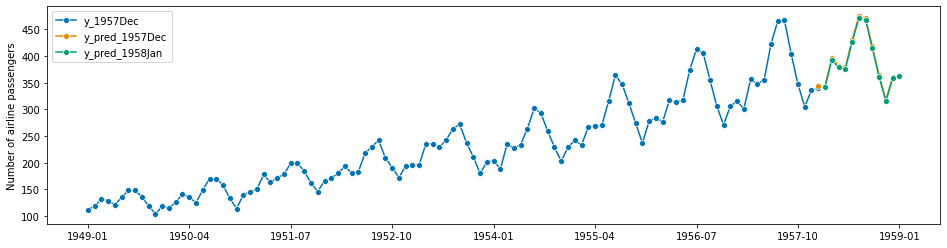

In [36]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan"],
)

In [37]:
# February 1958

# new data is observed:
y_1958Feb = y[[-35]]

# step 5: we update the forecaster with the new data
forecaster.update(y_1958Feb)

# step 6: making forecasts with the updated data
y_pred_1958Feb = forecaster.predict(fh)

/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:1097: UserWarning: NotImplementedWarning: AutoETS does not have a custom `update` method implemented. AutoETS will be refit each time `update` is called.
  warn(


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

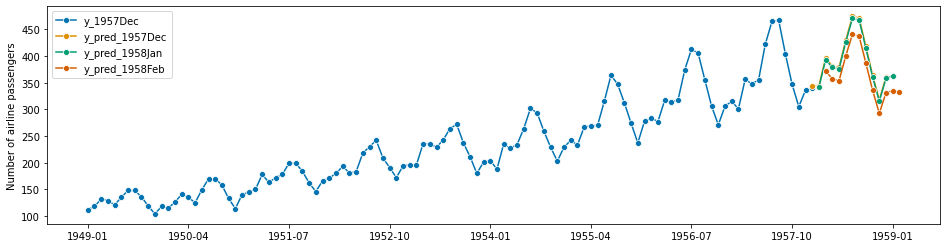

In [38]:
# plotting predictions and past data
plot_series(
    y[:-35],
    y_pred_1957Dec,
    y_pred_1958Jan,
    y_pred_1958Feb,
    labels=["y_1957Dec", "y_pred_1957Dec", "y_pred_1958Jan", "y_pred_1958Feb"],
)

... and so on.

A shorthand for running first `update` and then `predict` is `update_predict_single` - for some algorithms, this may be more efficient than the separate calls to `update` and `predict`:

In [39]:
# March 1958

# new data is observed:
y_1958Mar = y[[-34]]

# step 5&6: update/predict in one step
forecaster.update_predict_single(y_1958Mar, fh=fh)

/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:1097: UserWarning: NotImplementedWarning: AutoETS does not have a custom `update` method implemented. AutoETS will be refit each time `update` is called.
  warn(


1958-04    349.161733
1958-05    346.920333
1958-06    394.054912
1958-07    435.845496
1958-08    433.322360
1958-09    384.849639
1958-10    335.540594
1958-11    293.177215
1958-12    333.278828
1959-01    338.596459
1959-02    336.983414
1959-03    388.122274
Freq: M, dtype: float64

### 1.5 advanced evaluation worfklow: rolling re-sampling and aggregate errors, rolling back-testing<a class="anchor" id="section_1_5"></a>

To evaluate forecasters with respect to their performance in rolling forecasting, the forecaster needs to be tested in a set-up mimicking rolling forecasting, usually on past data. Note that the batch back-testing as in Section 1.3 would not be an appropriate evaluation set-up for rolling deployment, as that tests only a single forecast batch. 

The advanced evaluation workflow can be carried out using the `evaluate` benchmarking function.
`evalute` takes as arguments:
- a `forecaster` to be evaluated
- a `scikit-learn` re-sampling strategy for temporal splitting (`cv` below), e.g., `ExpandingWindowSplitter` or `SlidingWindowSplitter`
- a `strategy` (string): whether the forecaster should be always be refitted or just fitted once and then updated

In [44]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

In [45]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,cutoff,fit_time,len_train_window,pred_time,test_MeanAbsolutePercentageError
0,1954-12,2.598064,72,0.005687,0.064381
1,1955-12,2.963252,84,0.005128,0.051731
2,1956-12,4.149905,96,0.003965,0.030455
3,1957-12,1.878711,108,0.003962,0.052028
4,1958-12,2.702192,120,0.005694,0.076921
5,1959-12,5.949172,132,0.004989,0.030936


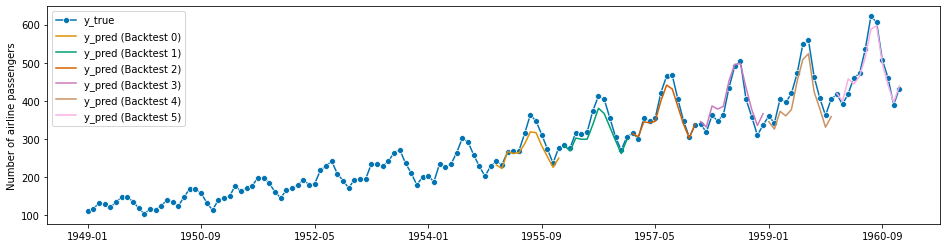

In [46]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

todo: performance metrics, averages, and testing - contributions to `sktime` and the tutorial are welcome.

## 2. Forecasters in `sktime` - main families<a class="anchor" id="chapter2"></a>

`sktime` supports a number of commonly used forecasters, many of them interfaced from state-of-art forecasting packages. All forecasters are available under the unified `sktime` interface.

The main classes that are currently stably supported are:

* `ExponentialSmoothing`, `ThetaForecaster`, and `autoETS` from `statsmodels`
* `ARIMA` and `autoARIMA` from `pmdarima`
* `BATS` and `TBATS` from `tbats`
* `PolynomialTrend` for forecasting polynomial trends
* `Prophet` which interfaces Facebook `prophet`

For illustration, all estimators below will be presented on the basic forecasting workflow - though they also support the advanced forecasting and evaluation workflows under the unified `sktime` interface (see Section 1).

For use in the other workflows, simply replace the "forecaster specification block" ("`forecaster=`") by the forecaster specification block in the examples presented below.

Generally, all forecasters available in `sktime` can be listed with the `all_estimators` command:

In [47]:
from sktime.registry import all_estimators

In [48]:
import pandas as pd

In [49]:
# all_estimators returns list of pairs - data frame conversion for pretty printing
all_estimators("forecaster", as_dataframe=True)

/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'esig'. 'esig' is a soft dependency and not included in the sktime installation. Please run: `pip install esig`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'fbprophet'. 'fbprophet' is a soft dependency and not included in the sktime installation. Please run: `pip install fbprophet`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'hcrystalball'. 'hcrystalball' is a soft dependency and not included in the sktime installation. Please run: `pip install hcrystalball`

,name,estimator
0,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,BATS,<class 'sktime.forecasting.bats.BATS'>
5,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
6,Croston,<class 'sktime.forecasting.croston.Croston'>
7,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
8,DirRecTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
9,DirectTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...


All forecasters follow the same interface, and can be used in the workflows presented in Section 1.

We proceed by showcasing some commonnly used classes of forecasters.

In [50]:
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

### 2.1 exponential smoothing, theta forecaster, autoETS from `statsmodels`<a class="anchor" id="section_2_1"></a>

`sktime` interfaces a number of statistical forecasting algorithms from `statsmodels`: exponential smoothing, theta, and aut-ETS.

For example, to use exponential smoothing with an additive trend component and multiplicative seasonality on the airline data set, we can write the following.

Note that since this is monthly data, a good choic for seasonal periodicity (sp) is 12 (= hypothesized periodicity of a year).

In [51]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.05027662159649058

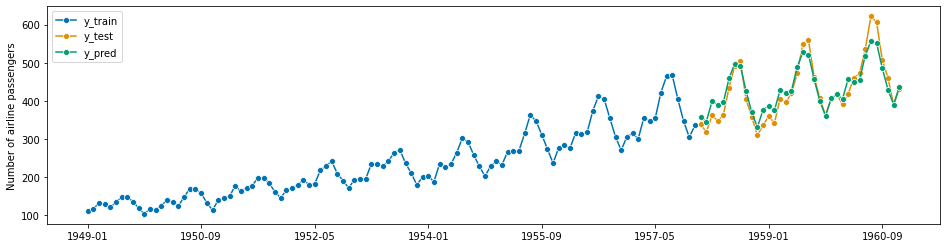

In [52]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

The exponential smoothing of state space model can also be automated similar
 to the [ets](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/ets) function in R. This is implemented in the `AutoETS` forecaster.

In [53]:
from sktime.forecasting.ets import AutoETS

0.06317430647002534

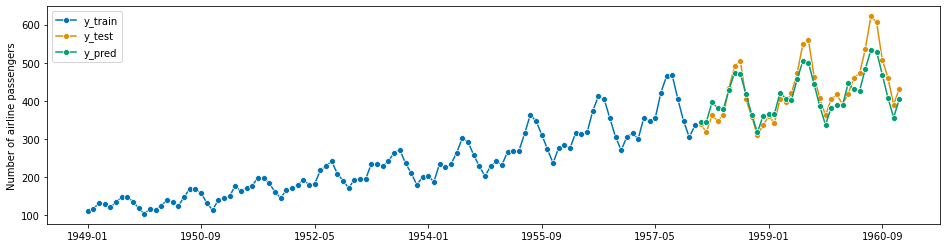

In [54]:
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [55]:
# todo: explain Theta; explain how to get theta-lines

### 2.2 ARIMA and autoARIMA<a class="anchor" id="section_2_2"></a>

`sktime` interfaces `pmdarima` for its ARIMA class models.
For a classical ARIMA model with set parameters, use the `ARIMA` forecaster:

In [56]:
from sktime.forecasting.arima import ARIMA

0.04257105757347649

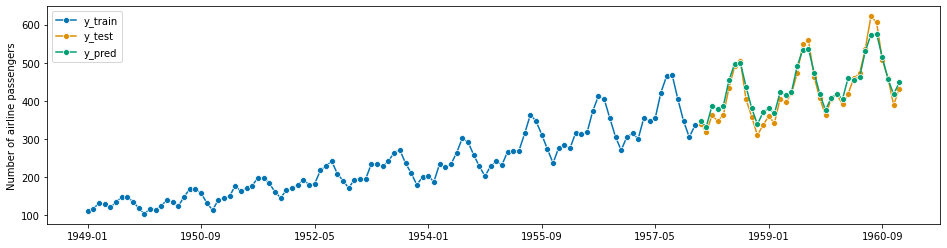

In [57]:
forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

`AutoARIMA` is an automatically tuned `ARIMA` variant that obtains the optimal pdq parameters automatically:

In [58]:
from sktime.forecasting.arima import AutoARIMA

0.04117062367046531

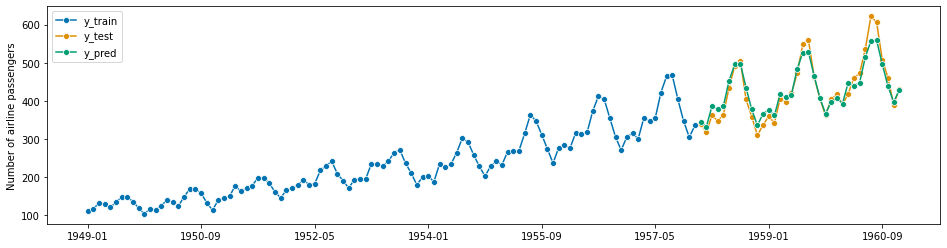

In [59]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [60]:
# to obtain the fitted parameters, run
forecaster.get_fitted_params()
# should these not include pdq?

{'ar.L1': -0.2411177593160947,
 'sigma2': 92.74985957133522,
 'aic': 704.0011679025909,
 'aicc': 704.1316026851996,
 'bic': 709.108921685792,
 'hqic': 706.0650836395923}

### 2.3 BATS and TBATS<a class="anchor" id="section_2_3"></a>

`sktime` interfaces BATS and TBATS from the [`tbats`](https://github.com/intive-DataScience/tbats) package.

In [61]:
from sktime.forecasting.bats import BATS

0.08689500982369815

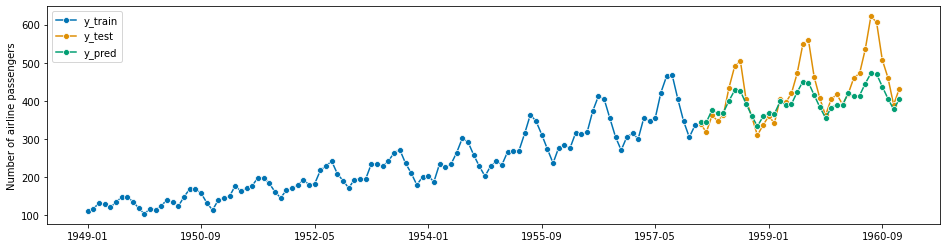

In [62]:
forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [63]:
from sktime.forecasting.tbats import TBATS

0.08493353477049964

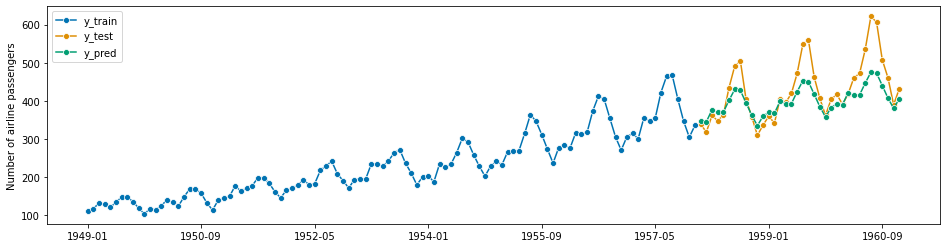

In [64]:
forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

### 2.4 Facebook prophet<a class="anchor" id="section_2_4"></a>

`sktime` provides an interface to [`fbprophet`](https://github.com/facebook/prophet) by Facebook.

In [68]:
from sktime.forecasting.fbprophet import Prophet

The current interface does not support period indices, only pd.DatetimeIndex.

Consider improving this by contributing the `sktime`.

In [69]:
# Convert index to pd.DatetimeIndex
z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=36)

0.06976085803353164

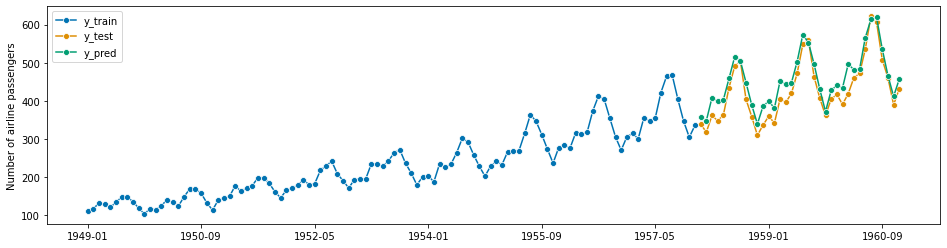

In [70]:
forecaster = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={"country_name": "Germany"},
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

### 2.5 State Space Model (Structural Time Series)<a class="anchor" id="section_2_5"></a>

We can also use the [`UobservedComponents`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html) class from [`statsmodels`](https://www.statsmodels.org/stable/index.html) to generate predictions using a state space model.

In [71]:
from sktime.forecasting.structural import UnobservedComponents

0.048733315277388556

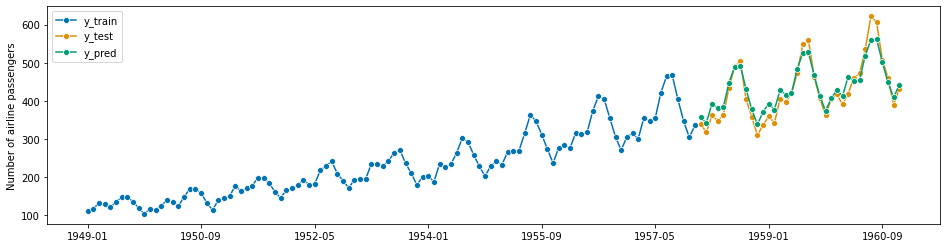

In [72]:
# We can model seasonality using Fourier modes as in the Prophet model.
forecaster = UnobservedComponents(
    level="local linear trend", freq_seasonal=[{"period": 12, "harmonics": 10}]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## 3. Advanced composition patterns - pipelines, reduction, autoML, and more<a class="anchor" id="chapter3"></a>

`sktime` supports a number of advanced composition patterns to create forecasters out of simpler components:

* reduction - building a forecaster from estimators of "simpler" scientific types, like `scikit-learn` regressors. A common example is feature/label tabulation by rolling window, aka the "direct reduction strategy".
* tuning - determining values for hyper-parameters of a forecaster in a data-driven manner. A common example is grid search on temporally rolling re-sampling of train/test splits.
* pipelining - concatenating transformers with a forecaster to obtain one forecaster. A common example is detrending and deseasonalizing then forecasting, an instance of this is the common "STL forecaster".
* autoML, also known as automated model selection - using automated tuning strategies to select not only hyper-parameters but entire forecasting strategies. A common example is on-line multiplexer tuning.

For illustration, all estimators below will be presented on the basic forecasting workflow - though they also support the advanced forecasting and evaluation workflows under the unified `sktime` interface (see Section 1).

For use in the other workflows, simply replace the "forecaster specification block" ("`forecaster=`") by the forecaster specification block in the examples presented below.

In [73]:
# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

### 3.1 Reduction: from forecasting to regression<a class="anchor" id="section_3_1"></a>

`sktime` provides a meta-estimator that allows the use of any `scikit-learn` estimator for forecasting.

* **modular** and **compatible with scikit-learn**, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,
* **parametric** and **tuneable**, allowing us to tune hyper-parameters such as the window length or strategy to generate forecasts
* **adaptive**, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

In [141]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sktime.forecasting.compose import make_reduction

In [142]:
#regressor = KNeighborsRegressor(n_neighbors=1)
regressor = GradientBoostingRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

0.11226991983559136

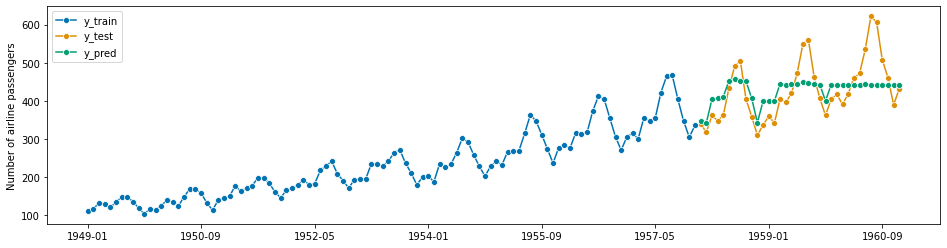

In [143]:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In the above example we use the "recursive" reduction strategy. Other implemented strategies are: 
* "direct", 
* "dirrec", 
* "multioutput". 

Parameters can be inspected using `scikit-learn` compatible `get_params` functionality (and set using `set_params`). This provides tunable and nested access to parameters of the `KNeighborsRegressor` (as `estimator_etc`), and the `window_length` of the reduction strategy. Note that the `strategy` is not accessible, as underneath the utility function this is mapped on separate algorithm classes. For tuning over algorithms, see the "autoML" section below. 

In [144]:
forecaster.get_params()

{'estimator__alpha': 0.9,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'squared_error',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': None,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingRegressor(),
 'window_length': 15}

### 3.2 Pipelining, detrending and deseasonalization<a class="anchor" id="section_3_2"></a>

A common composition motif is pipelining: for example, first deseasonalizing or detrending the data, then forecasting the detrended/deseasonalized series. When forecasting, one needs to add the trend and seasonal component back to the data. 

#### 3.2.1 The basic forecasting pipeline<a class="anchor" id="section_3_2_1"></a>

`sktime` provides a generic pipeline object for this kind of composite modelling, the `TransforemdTargetForecaster`. It chains an arbitrary number of transformations with a forecaster. The transformations should be instances of estimators with series-to-series-transformer scitype. An example of the syntax is below:

In [78]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


0.15497687758446174

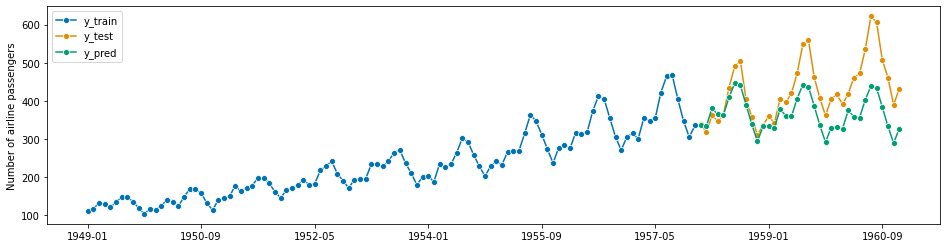

In [79]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

The `TransformedTargetForecaster` is constructed with a list of steps, each a pair of name and estimator. The last estimator should be of forecaster scitype, the other estimators should be series-to-series transformers which possess both a `transform` and `inverse_transform` method. The resulting estimator is of forecaster scitype and has all interface defining methods. In `fit`, all transformers apply `fit_transforms` to the data, then the forecaster's `fit`; in `predict`, first the forecaster's `predict` is applied, then the transformers' `inverse_transform` in reverse order.

#### 3.2.2 The `Detrender` as pipeline component<a class="anchor" id="section_3_2_2"></a>

For detrending, we can use the `Detrender`. This is an estimator of series-to-transformer scitype that wraps an arbitrary forecaster. For example, for linear detrending, we can use `PolynomialTrendForecaster` to fit a linear trend, and then subtract/add it using the `Detrender` transformer inside `TransformedTargetForecaster`.

To understand better what happens, we first examine the detrender separately:

In [80]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

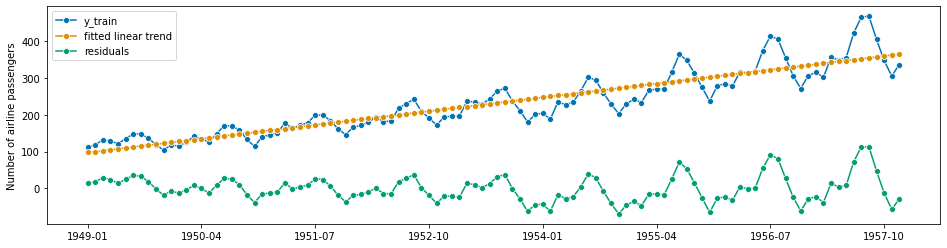

In [81]:
# linear detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

Since the `Detrender` is of scitype series-to-series-transformer, it can be used in the `TransformedTargetForecaster` for detrending any forecaster:

0.05755295634414375

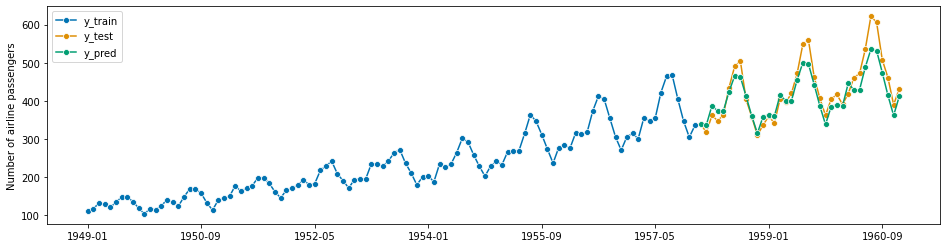

In [82]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

#### 3.2.3 Complex pipeline composites and parameter inspection<a class="anchor" id="section_3_2_3"></a>

`sktime` follows the `scikit-learn` philosophy of composability and nested parameter inspection. As long as an estimator has the right scitype, it can be used as part of any composition principle requiring that scitype. Above, we have already seen the example of a forecaster inside a `Detrender`, which is an estimator of scitype series-to-series-transformer, with one component of forecaster scitype. Similarly, in a `TransformedTargetForecaster`, we can use the reduction composite from Section 3.1 as the last forecaster element in the pipeline, which inside has an estimator of tabular regressor scitype, the `KNeighborsRegressor`:

In [83]:

from sktime.forecasting.compose import make_reduction

0.05415230988088083

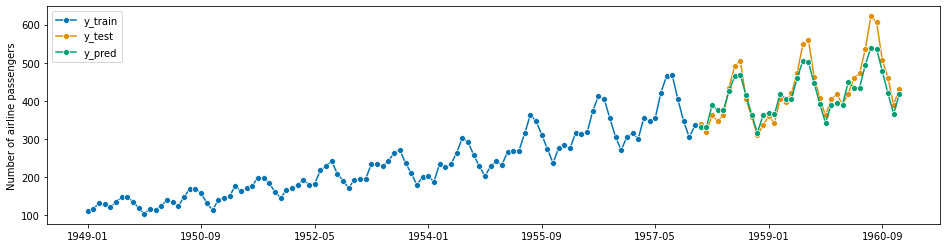

In [139]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
               # KNeighborsRegressor(),
                GradientBoostingRegressor(learning_rate=0.05),
                scitype="tabular-regressor",
                window_length=15,
                strategy="recursive",
            ),
        ),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

As with `scikit-learn` models, we can inspect and access parameters  of any component via `get_params` and `set_params`:

In [122]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                        window_length=15))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                      window_length=15),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__alpha': 0.9,
 'forecast__estimator__ccp_alpha': 0.0,
 'forecast__estimator__criterion': 'friedman_mse',
 'forecast__estimator__init': None,
 'forecast__estimator

### 3.3 Parameter tuning<a class="anchor" id="section_3_3"></a>

`sktime` provides parameter tuning strategies as compositors of forecaster scitype, similar to `scikit-learn`'s `GridSearchCV`.

### 3.3.1 Basic tuning using `ForecastingGridSearchCV`<a class="anchor" id="section_3_3_1"></a>

The compositor `ForecastingGridSearchCV` (and other tuners) are constructed with a forecaster to tune, a cross-validation constructor, a `scikit-learn` parameter grid, and parameters specific to the tuning strategy. Cross-validation constructors follow the `scikit-learn` interface for re-samplers, and can be slotted in exchangeably.

As an example, we show tuning of the window length in the reduction compositor from Section 3.1, using temporal sliding window tuning:

In [86]:

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [130]:
regressor = GradientBoostingRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper=parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

In [132]:
regressor.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

As with other composites, the resulting forecaster provides the unified interface of `sktime` forecasters - window splitting, tuning, etc requires no manual effort and is done behind the unified interface:

In [131]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

ValueError: Invalid parameter n_estimators for estimator TransformedTargetForecaster(steps=[('deseasonalize',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=12)),
                                   ('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor(),
                                                                         window_length=15))]). Check the list of available parameters with `estimator.get_params().keys()`.

Tuned parameters can be accessed in the `best_params_` attribute:

In [89]:
gscv.best_params_

{'window_length': 7}

An instance of the best forecaster, with hyper-parameters set, can be retrieved by accessing the `best_forecaster_` attribute:

In [90]:
gscv.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                     window_length=7)

### 3.3.2 Tuning of complex composites<a class="anchor" id="section_3_3_2"></a>

As in `scikit-learn`, parameters of nested components can be tuned by accessing their `get_params` key - by default this is `[estimatorname]__[parametername]` if `[estimatorname]` is the name of the component, and `[parametername]` the name of a parameter within the estimator `[estimatorname]`. 

For example, below we tune the `KNeighborsRegressor` component's `n_neighbors`, in addition to tuning `window_length`. The tuneable parameters can easily be queried using `forecaster.get_params()`.

In [91]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [92]:
param_grid = {"window_length": [7, 12, 15], "estimator__n_neighbors": np.arange(1, 10)}

regressor = KNeighborsRegressor()
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

0.1539546827317818

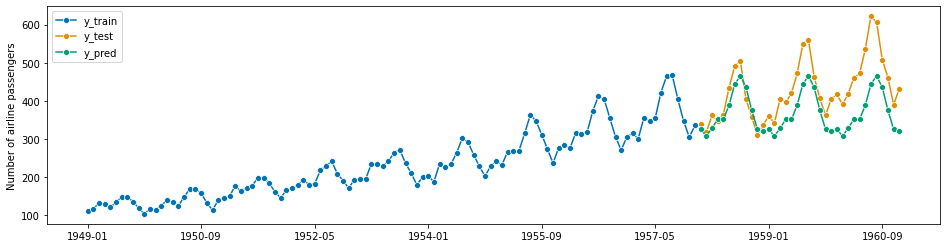

In [93]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

In [94]:
gscv.best_params_

{'estimator__n_neighbors': 2, 'window_length': 12}

An alternative to the above is tuning the regressor separately, using `scikit-learn`'s `GridSearchCV` and a separate parameter grid. As this does not use the "overall" performance metric to tune the inner regressor, performance of the composite forecaster may vary.

In [95]:
from sklearn.model_selection import GridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_neighbors": np.arange(1, 10)}
forecaster_param_grid = {"window_length": [7, 12, 15]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(KNeighborsRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

0.15992807470665493

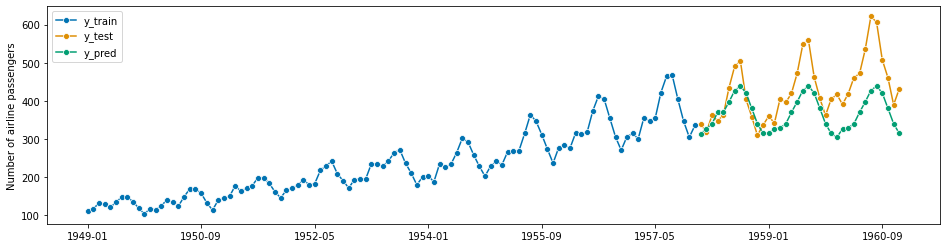

In [96]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

NOTE: a smart implementation of this would use caching to save partial results from the inner tuning and reduce runtime substantially - currently `sktime` does not support this. Consider helping to improve `sktime`.

### 3.3.3 Selecting the metric and retrieving scores<a class="anchor" id="section_3_3_3"></a>

All tuning algorithms in `sktime` allow the user to set a score; for forecasting the default is mean absolute percentage error. The score can be set using the `score` argument, to any scorer function or class, as in Section 1.3.

Re-sampling tuners retain performances on individual forecast re-sample folds, which can be retrieved from the `cv_results_` argument after the forecaster has been fit via a call to `fit`.

In the above example, using the mean squared error instead of the mean absolute percentage error for tuning would be done by defining the forecaster as follows:

In [97]:
from sktime.performance_metrics.forecasting import MeanSquaredError

In [98]:
mse = MeanSquaredError()

param_grid = {"window_length": [7, 12, 15]}

regressor = KNeighborsRegressor()
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, scoring=mse)

The performances on individual folds can be accessed as follows, after fitting:

In [99]:
gscv.fit(y_train)
gscv.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,2600.750255,0.050037,0.002372,{'window_length': 7},3.0
1,1134.999053,0.052081,0.002537,{'window_length': 12},1.0
2,1285.133614,0.046920,0.002233,{'window_length': 15},2.0


###  3.4 autoML  aka automated model selection, ensembling and hedging<a class="anchor" id="section_3_4"></a>

`sktime` provides a number of compositors for ensembling and automated model selection. In contrast to tuning, which uses data-driven strategies to find optimal hyper-parameters for a fixed forecaster, the strategies in this section combine or select on the level of estimators, using a collection of forecasters to combine or select from.

The strategies discussed in this section are:
* autoML aka automated model selection
* simple ensembling
* prediction weighted ensembles with weight updates, and hedging strategies

###  3.4.1 autoML aka automatic model selection, using tuning plus multiplexer<a class="anchor" id="section_3_4_1"></a>

The most flexible way to perform model selection over forecasters is by using the `MultiplexForecaster`, which exposes the choice of a forecaster from a list as a hyper-parameter that is tunable by generic hyper-parameter tuning strategies such as in Section 3.3.

In isolation, `MultiplexForecaster` is constructed with a named list `forecasters`, of forecasters. It has a single hyper-parameter, `selected_forecaster`, which can be set to the name of any forecaster in `forecasters`, and behaves exactly like the forecaster keyed in `forecasters` by `selected_forecaster`.

In [100]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster

In [101]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

In [102]:
forecaster.set_params(**{"selected_forecaster": "naive"})
# now forecaster behaves like NaiveForecaster(strategy="last")

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='naive')

In [103]:
forecaster.set_params(**{"selected_forecaster": "ets"})
# now forecaster behaves like ExponentialSmoothing(trend="add", sp=12))

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='ets')

The `MultiplexForecaster` is not too useful in isolation, but allows for flexible autoML when combined with a tuning wrapper. The below defines a forecaster that selects one of `NaiveForecaster` and `ExponentialSmoothing` by sliding window tuning as in Section 3.3.

Combined with rolling use of the forecaster via the `update` functionality (see Section 1.4), the tuned multiplexer can switch back and forth between `NaiveForecaster` and `ExponentialSmoothing`, depending on performance, as time progresses.

In [104]:
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [105]:
forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ]
)
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=30)
forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

0.23195770387951434

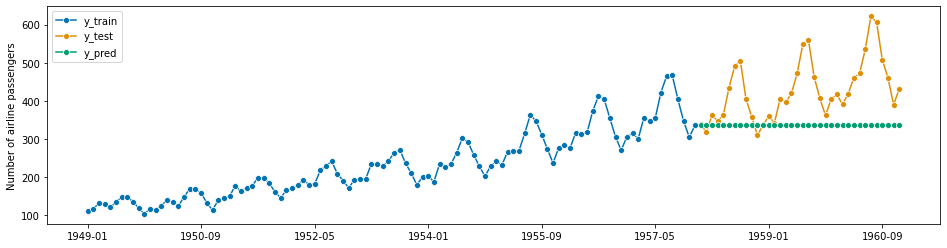

In [106]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

As with any tuned forecaster, best parameters and an instance of the tuned forecaster can be retrieved using `best_params_` and `best_forecaster_`:

In [107]:
gscv.best_params_

{'selected_forecaster': 'naive'}

In [108]:
gscv.best_forecaster_

MultiplexForecaster(forecasters=[('naive', NaiveForecaster()),
                                 ('ets',
                                  ExponentialSmoothing(sp=12, trend='add'))],
                    selected_forecaster='naive')

### 3.4.2 autoML: selecting transformer combinations via `OptimalPassthrough`<a class="anchor" id="section_3_4_2"></a>

`sktime` also provides capabilities for automated selection of pipeline components *inside* a pipeline, i.e., pipeline structure. This is achieved with the `OptionalPassthrough` transformer.

The `OptionalPassthrough` transformer allows to tune whether a transformer inside a pipeline is applied to the data or not. For example, if we want to tune whether `sklearn.StandardScaler` is bringing an advantage to the forecast or not, we wrap it in `OptionalPassthrough`. Internally, `OptionalPassthrough` has a hyperparameter `passthrough: bool` that is tuneable; when `False` the composite behaves like the wrapped transformer, when `True`, it ignores the transformer within.

To make effective use of `OptionalPasstrhough`, define a suitable parameter set using the `__` (double underscore) notation familiar from `scikit-learn`. This allows to access and tune attributes of nested objects like TabularToSeriesAdaptor(StandardScaler()). We can use `__` multiple times if we have more than two levels of nesting.

In the following example, we take a deseasonalize/scale pipeline and tune over the four possible combinations of deseasonalizer and scaler being included in the pipeline yes/no (2 times 2 = 4); as well as over the forecaster's and the scaler's parameters.

Note: this could be arbitrarily combined with `MultiplexForecaster`, as in Section 3.4.1, to select over pipeline architecture as well as over pipeline structure.

Note: `scikit-learn` and `sktime` do not support conditional parameter sets at current (unlike, e.g., the `mlr3` package). This means that the grid search will optimize over the `scaler`'s parameters even when it is skipped. Designing/implementing this capability would be an interesting area for contributions or research.

In [109]:
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_airline
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [110]:
# create pipeline
pipe = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("forecaster", NaiveForecaster()),
    ]
)

# putting it all together in a grid search
cv = SlidingWindowSplitter(
    initial_window=60, window_length=24, start_with_window=True, step_length=24
)
param_grid = {
    "deseasonalizer__passthrough": [True, False],
    "scaler__transformer__transformer__with_mean": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__strategy": ["drift", "mean", "last"],
}
gscv = ForecastingGridSearchCV(forecaster=pipe, param_grid=param_grid, cv=cv, n_jobs=-1)

0.14474716829798706

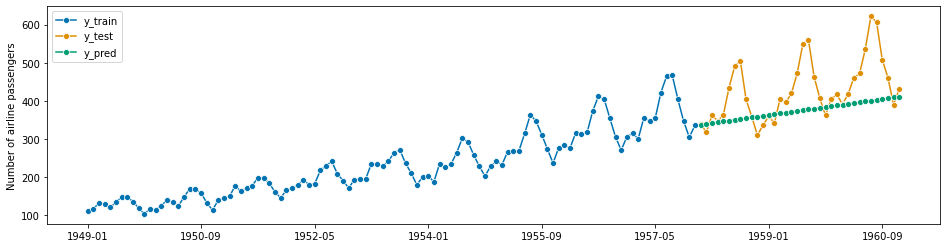

In [111]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

###  3.4.3 simple ensembling strategies<a class="anchor" id="section_3_4_3"></a>

TODO - contributions in this section are appreciated

In [112]:
from sktime.forecasting.compose import EnsembleForecaster

0.19012216255559186

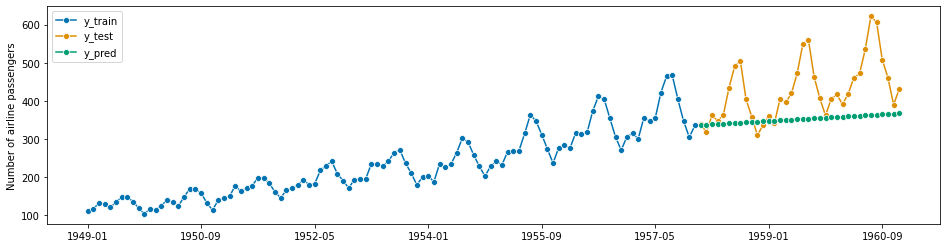

In [113]:
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)

forecaster = EnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

### 3.4.4 Prediction weighted ensembles and hedge ensembles<a class="anchor" id="section_3_4_4"></a>

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, we can leverage the forecasters from the `online_forecasting` module which use a composite forecaster, `PredictionWeightedEnsemble`, to keep track of the loss accumulated by each forecaster and create a prediction weighted by the predictions of the most "accurate" forecasters.

Note that the forecasting task is changed: we make 35 predictions since we need the first prediction to help update the weights, we do not predict 36 steps ahead.

In [114]:
from sktime.forecasting.all import mean_squared_error
from sktime.forecasting.online_learning import (
    NormalHedgeEnsemble,
    OnlineEnsembleForecaster,
)

First we need to initialize a `PredictionWeightedEnsembler` that will keep track of the loss accumulated by each forecaster and define which loss function we would like to use.

In [115]:
hedge_expert = NormalHedgeEnsemble(n_estimators=3, loss_func=mean_squared_error)

We can then create the forecaster by defining the individual forecasters and specifying the `PredictionWeightedEnsembler` we are using. Then by fitting our forecasters and performing updates and prediction with the `update_predict` function, we get:

/Users/danielcanueto/Documents/ml-platform/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:1097: UserWarning: NotImplementedWarning: ExponentialSmoothing does not have a custom `update` method implemented. ExponentialSmoothing will be refit each time `update` is called.
  warn(


0.09679488296848746

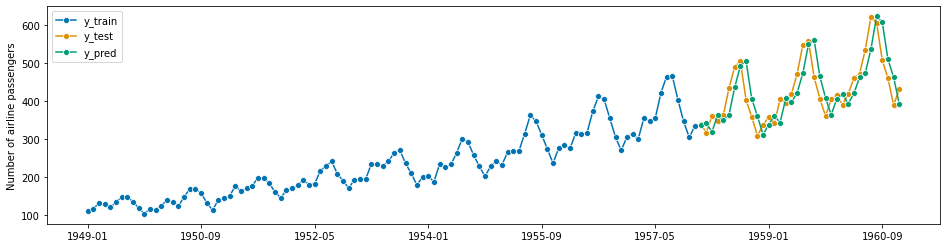

In [116]:
forecaster = OnlineEnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped),
    ],
    ensemble_algorithm=hedge_expert,
)

forecaster.fit(y=y_train, fh=fh)
y_pred = forecaster.update_predict_single(y_test)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

## 4. Extension guide - implementing your own forecaster<a class="anchor" id="chapter4"></a>

`sktime` is meant to be easily extensible, for direct contribution to `sktime` as well as for local/private extension with custom methods.

To extend `sktime` with a new local or contributed forecaster, a good workflow to follow is:

1. read through the [forecasting extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/forecasting.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. optionally, if you are planning any major surgeries to the interface: look at the [base class architecture](https://github.com/alan-turing-institute/sktime/blob/main/sktime/forecasting/base/_base.py) - note that "ordinary" extension (e.g., new algorithm) should be easily doable without this.
3. copy the forecasting extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `sktime` or affiliated repository (if contributed extension), inside `sktime.forecasting`; rename the file and update the file docstring appropriately.
4. address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, `_predict`, and optional methods such as `_update` (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
5. to test your estimator manually: import your estimator and run it in the worfklows in Section 1; then use it in the compositors in Section 3.
6. to test your estimator automatically: call `sktime.tests.test_all_estimators.test_estimator` on your estimator - note that the function takes the class, not an object instance. Before the call, you need to register the new estimator in `sktime.tests._config`, as an import, and by adding default parameter settings to the `ESTIMATOR_TEST_PARAMS` variable (the `dict` entry `key` is the class, and entry is a `scikit-learn` parameter set). `pytest` will also add the call to its automated tests in a working clone of the `sktime` repository.

In case of direct contribution to `sktime` or one of its affiliated packages, additionally:
* add yourself as an author to the code, and to the `CODEOWNERS` for the new estimator file(s).
* create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* in the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

## 5. Summary<a class="anchor" id="chapter5"></a>

* `sktime` comes with several forecasting algorithms (or forecasters), all of which share a common interface. The interface is fully interoperable with the `scikit-learn` interface, and provides dedicated interface points for forecasting in batch and rolling mode.

* `sktime` comes with rich composition functionality that allows to build complex pipelines easily, and connect easily with other parts of the open source ecosystem, such as `scikit-learn` and individual algorithm libraries.

* `sktime` is easy to extend, and comes with user friendly tools to facilitate implementing and testing your own forecasters and composition principles.


## Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).